# Exercises
Introduce Experience Replay and Fixed Target Q-Networks into the DQN algorithm.

## Imports and setup optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import animation, rc
from  dataclasses import dataclass, field
from typing import List
import collections
import tensorflow as tf

2023-03-09 16:21:55.917109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Experience class for replay

In [2]:
@dataclass
class Experience:
    state: np.ndarray = np.array([[]])
    next_state: np.ndarray = np.array([[]])
    action: List[int] = field(default_factory=list)
    reward: int = 0
    terminal: bool = False

## Brain class

In [3]:
class Brain:
    # initialize the brain of the agent with the following parameters
    # build the model
    def __init__(self, n_states, n_hidden, n_actions, gamma=0.9, r=0.99):
        self.epsilon = 1.0 # initial exploration rate
        self.gamma = gamma # discount factor
        self.r = r # decay rate of epsilon

        # build the model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(n_hidden, input_shape=(None,n_states,), activation='relu'))
        model.add(tf.keras.layers.Dense(n_hidden, activation='relu'))
        model.add(tf.keras.layers.Dense(n_hidden, activation='relu'))
        model.add(tf.keras.layers.Dense(n_actions, activation='linear'))
        self.model = model

        # define the loss function
        self.loss_fn = tf.keras.losses.MeanSquaredError()

        # define the optimizer
        self.optimizer = tf.keras.optimizers.Adam()

    # train the model with the minibatch
    def train(self, q_next, states_batch, rewards_batch, terminal_batch):

        rewards_batch = rewards_batch.reshape(-1, 1)
        terminal_batch = terminal_batch.reshape(-1, 1)
        
        # target is the reward + discounted Q value of the next state
        target_values = rewards_batch + self.gamma * np.max(q_next, axis=1) * (1 - terminal_batch)
        
        # train the model
        self._train_on_batch(states_batch, target_values)

    # _train_on_batch is a wrapper for the keras train_on_batch function
    @tf.function
    def _train_on_batch(self, states_batch, target_values):
        with tf.GradientTape() as tape:
            y_pred = self.model(states_batch)
            # get the loss
            loss = self.loss_fn(target_values, y_pred)

        # get the variables
        variables = self.model.trainable_variables
        
        # get the gradients
        gradients = tape.gradient(loss, variables)

        # update the weights
        self.optimizer.apply_gradients(zip(gradients, variables))

    # get the Q value of the state
    def get_q(self, states):
        return self.model(states)

    # get the action with the epsilon-greedy policy
    def get_action(self, state):
        q = self.get_q(np.array([state]))[0]
        if np.random.rand() < self.epsilon:
            action =  np.random.randint(q.shape[1], size=q.shape[0])
        else:
            action = np.argmax(q, axis=1)
        if self.epsilon > 0.1: # decay the exploration rate
            self.epsilon *= self.r
        return action

## Agent class

In [4]:
class Agent:
    # initialize the agent with the following action parameters
    def __init__(self, v_x, v_y_sigma, v_jump, brain, target_brain):
        self.v_x = v_x # velocity in the x direction
        self.v_y_sigma = v_y_sigma # std of the velocity in the y direction
        self.v_jump = v_jump # velocity in the y direction when the agent jumps
        self.experiences = collections.deque(maxlen=50000) # store the experiences
        self.batch_size = 32 # mini-batch size
        self.brain = brain # the brain of the agent
        self.target_brain = target_brain # the target brain of the agent
        self.reset()

    # reset the agent position and velocity in the y direction
    # initial position is (x, y) = (-1, 0)
    # initial velocity in the y direction is randomly sampled from a normal distribution
    def reset(self):
        self.x = -1. # x position
        self.y = 0. # y position
        self.v_y = self.v_y_sigma * np.random.randn() # y velocity

    # update the target brain
    def update_target_brain(self):
        self.target_brain.model.set_weights(self.brain.model.get_weights())

    # get the mini-batch from the experience replay
    def get_batch(self, batch_size):
        # randomly sample the experiences for the mini-batch
        batch = np.random.choice(self.experiences, batch_size)
        states_batch = np.array([e.state for e in batch])
        next_states_batch = np.array([e.next_state for e in batch])
        actions_batch = np.array([e.action for e in batch])
        rewards_batch = np.array([e.reward for e in batch])
        terminal_batch = np.array([e.terminal for e in batch])
        return states_batch, next_states_batch, actions_batch, rewards_batch, terminal_batch

    # update the agent steate, reward, and brain
    # the reward is 0 if the agent position is y = -1 or y = 1
    # the reward is 1 if the agent position is x = 1
    # if the agent jumps, the velocity in the y direction is updated by the jump velocity
    # if the agent does not jump, the velocity in the y direction is updated by the gravity
    def step(self, g):
        # get the current state
        state = np.array([[self.y, self.v_y]])

        # update the agent position and get the reward and terminal
        self.x += self.v_x
        self.y += self.v_y
        reward = 0
        terminal = False 
        if self.y < -1.0 or self.y > 1.0:
            reward = -1
            terminal = True
        elif self.x > 1.0:
            reward = 1
            terminal = True
        reward = np.array([reward])
        
        # get the action from the target brain and get the next state
        action = self.target_brain.get_action(state)
        if action[0] == 0:
            self.v_y -= g
        else:
            self.v_y = self.v_jump
        next_state = np.array([[self.y, self.v_y]])

        # store the experience
        exp = Experience(state, next_state, action, reward, terminal)
        self.experiences.append(exp)

        return reward, terminal

    def train_brain(self):
        # get the mini-batch
        batch_size = min(self.batch_size, len(self.experiences))
        states_batch, next_states_batch, actions_batch, rewards_batch, terminal_batch = self.get_batch(batch_size)

        # get the next Q value from the target brain
        q_next = self.target_brain.get_q(next_states_batch)
        
        # train the brain with the mini-batch
        self.brain.train(q_next, states_batch, rewards_batch, terminal_batch)

## Environment class

In [5]:
class Enviroment:
    # initialize the enviroment with the following parameters
    def __init__(self, agent, g):
        self.g = g
        self.agent = agent

    # advance the agent by one step
    def step(self):
        return self.agent.step(self.g)
    
    # reset the agent
    def reset(self):
        self.agent.reset()

## Training

In [6]:
# train the agent and show the animation
# build the q-net brain and target brain
n_states = 2 # number of states
n_hidden = 32 # number of hidden units
n_actions = 2 # number of actions
q_net_brain = Brain(n_states, n_hidden, n_actions, r=0.999)
target_brain = Brain(n_states, n_hidden, n_actions, r=0.999)

# build the agent
v_x = 0.05 # velocity in the x direction
v_y_sigma = 0.1 # std of the velocity in the y direction
v_jump = 0.2 # velocity in the y direction when the agent jumps
agent = Agent(v_x, v_y_sigma, v_jump, q_net_brain, target_brain)

# build the enviroment
g = 0.2 # gravity
enviroment = Enviroment(agent, g)

# episode parameters
n_episodes = 1001 # number of episodes
reward_histroy = []
step_history = []
for episord in range(1,n_episodes):
    # reset the enviroment
    terminal = False
    enviroment.reset()
    step = 0

    while not terminal: # step until terminal
        step += 1
        # advance the enviroment by one step
        reward, terminal = enviroment.step()

        # end the step if terminal
        if terminal:
            # update agent
            agent.train_brain()

            # write the result
            step_history.append(step)
            reward_histroy.append(reward)
            break
    
    # the target brain updated every 5 episodes
    if episord % 5 == 0:
        agent.update_target_brain()

ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)

## Show the results

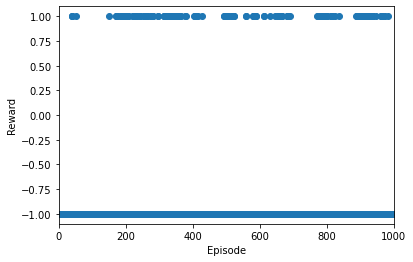

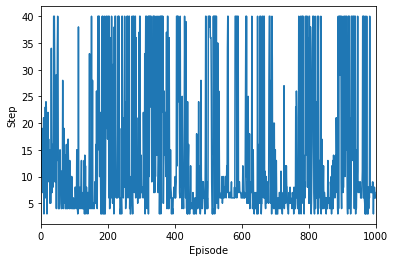

In [ ]:
x = np.arange(len(step_history))
fig, ax1 = plt.subplots()

# show the reward history
ax1.scatter(x, reward_histroy)
ax1.set_xlabel('Episode')
ax1.set_xlim([0, len(step_history)])
ax1.set_ylabel('Reward')
ax1.set_ylim([-1.1, 1.1])

# show the step history
fig, ax2 = plt.subplots()
ax2.plot(x, step_history)
ax2.set_xlabel('Episode')
ax2.set_xlim([0, len(step_history)])
ax2.set_ylabel('Step')

plt.show()